# start

from 0320_6; on gpubox

In [1]:
PRFX='0322_2'
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


['2020-03-17 02:32:24', '2020-03-17 00:30:47']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-22 14:37:44 chunk 0


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(1000000, 95)

In [10]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D65EE42A547283787FF5A

In [11]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [12]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 296 ms, sys: 322 ms, total: 618 ms
Wall time: 655 ms


In [13]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((850000, 91), (150000, 91), (850000, 4), (150000, 4))

In [14]:
tgt2ytr={tgt:ytr.iloc[:,i] for i,tgt in enumerate(tgts)}
tgt2yvl={tgt:yvl.iloc[:,i] for i,tgt in enumerate(tgts)}

# model

In [15]:
tgt2bst={}
tgt2evalres={}

tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': ['aucpr', 'logloss', ],
#     'max_delta_step': 1,
} for k in tgts}
tgt2params

{'Retweet': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'Reply': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'Like': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']},
 'RTwCmnt': {'objective': 'binary:logistic',
  'verbosity': 1,
  'eval_metric': ['aucpr', 'logloss']}}

In [16]:
def traintgt(tgt):
    evals_result = {}
    i=tgts.index(tgt)
    params = tgt2params[tgt]
    print(tgt, params)
    dtr = xgb.DMatrix(Xtr, label=tgt2ytr[tgt], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=tgt2yvl[tgt], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=1000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=10,
                    early_stopping_rounds=50)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
    return bst,evals_result

In [17]:
tgt='RTwCmnt'
tgt2bst[tgt],tgt2evalres[tgt] = traintgt(tgt)


{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.01364	train-logloss:0.44555	eval-aucpr:0.01209	eval-logloss:0.44525
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[10]	train-aucpr:0.02845	train-logloss:0.05146	eval-aucpr:0.01534	eval-logloss:0.05110
[20]	train-aucpr:0.04424	train-logloss:0.04240	eval-aucpr:0.01678	eval-logloss:0.04288
[30]	train-aucpr:0.05677	train-logloss:0.04128	eval-aucpr:0.01828	eval-logloss:0.04274
[40]	train-aucpr:0.07194	train-logloss:0.04055	eval-aucpr:0.01808	eval-logloss:0.04278
[50]	train-aucpr:0.08545	train-logloss:0.03993	eval-aucpr:0.01765	eval-logloss:0.04289
[60]	train-aucpr:0.10395	train-logloss:0.03933	eval-aucpr:0.01741	eval-logloss:0.04296
[70]	train-aucpr:0.11540	train-logloss:0.03899	eval-aucpr:0.01732	eval-logloss:0.04300
Stopping. Best iteration:
[26]	train-aucpr:0.05386	train-logloss:0.041

In [17]:
tgt='RTwCmnt'
tgt2bst[tgt],tgt2evalres[tgt] = traintgt(tgt)


{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.01364	train-logloss:0.44555	eval-aucpr:0.01209	eval-logloss:0.44525
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[10]	train-aucpr:0.02845	train-logloss:0.05146	eval-aucpr:0.01534	eval-logloss:0.05110
[20]	train-aucpr:0.04424	train-logloss:0.04240	eval-aucpr:0.01678	eval-logloss:0.04288
[30]	train-aucpr:0.05677	train-logloss:0.04128	eval-aucpr:0.01828	eval-logloss:0.04274
[40]	train-aucpr:0.07194	train-logloss:0.04055	eval-aucpr:0.01808	eval-logloss:0.04278
[50]	train-aucpr:0.08545	train-logloss:0.03993	eval-aucpr:0.01765	eval-logloss:0.04289
[60]	train-aucpr:0.10395	train-logloss:0.03933	eval-aucpr:0.01741	eval-logloss:0.04296
[70]	train-aucpr:0.11540	train-logloss:0.03899	eval-aucpr:0.01732	eval-logloss:0.04300
Stopping. Best iteration:
[26]	train-aucpr:0.05386	train-logloss:0.041

In [ ]:
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt, '*'*80)
    tgt2bst[tgt],tgt2evalres[tgt] = traintgt(tgt)
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

In [43]:
tgt2prdtr={}
tgt2prdvl={}
for tgt,bst in tgt2bst.items():
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    tgt2prdvl[tgt] = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)


2020-03-22 13:51:59 Like


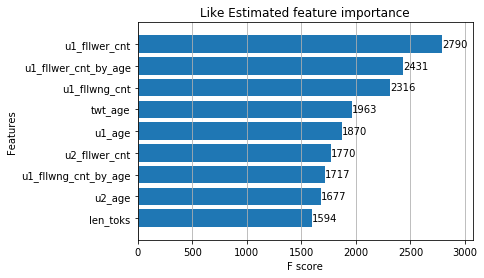

Like


,0,1
5,u1_fllwer_cnt,2790
4,u1_fllwer_cnt_by_age,2431
20,u1_fllwng_cnt,2316
14,twt_age,1963
6,u1_age,1870
11,u2_fllwer_cnt,1770
2,u1_fllwng_cnt_by_age,1717
8,u2_age,1677
3,len_toks,1594
13,u2_fllwng_cnt,1539


In [45]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

## valid

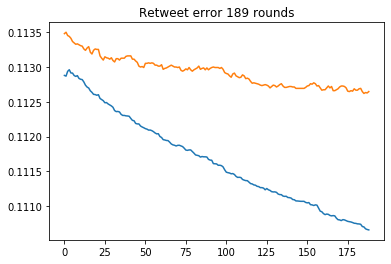

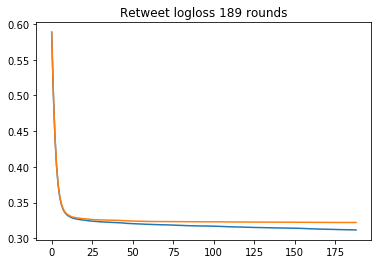

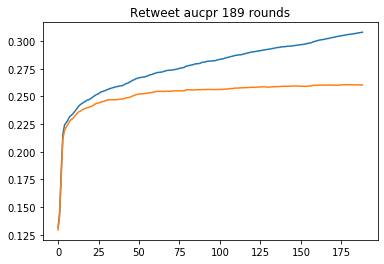

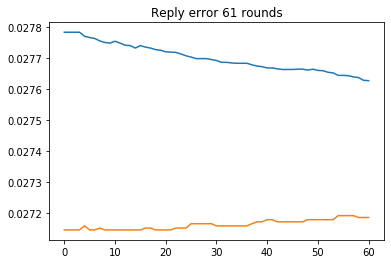

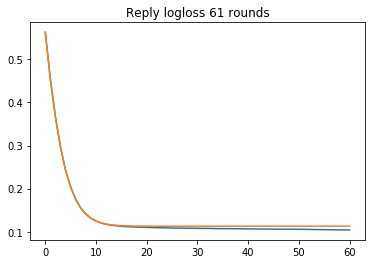

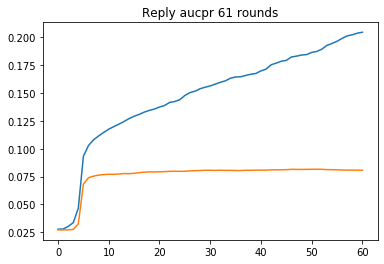

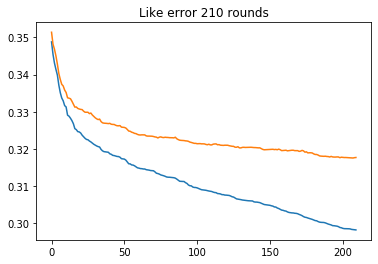

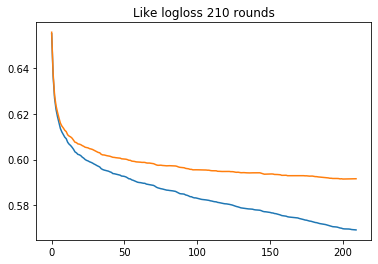

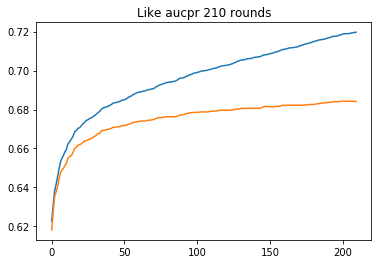

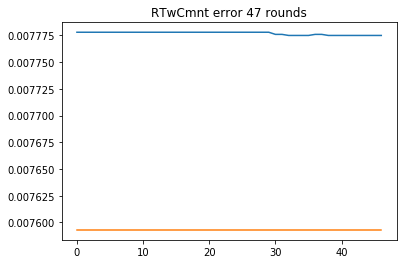

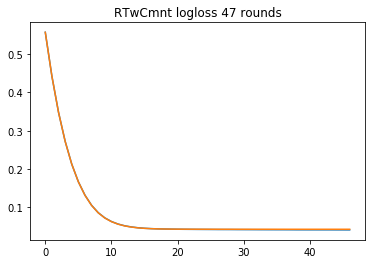

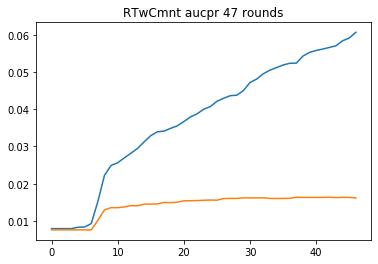

In [37]:
for tgt in tgt2evalres:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()
    


In [41]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    tgt2prdvl[tgt] = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    

2020-03-21 02:25:00 Retweet
2020-03-21 02:25:01 Reply
2020-03-21 02:25:02 Like
2020-03-21 02:25:03 RTwCmnt


In [42]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7411 valid auc: 0.7142
train prauc: 0.3060 valid auc: 0.2607
train rce: 11.5835 valid rce: 8.9732
Reply
train rocauc: 0.8269 valid auc: 0.7590
train prauc: 0.1873 valid auc: 0.0816
train rce: 16.8505 valid rce: 9.4530
Like
train rocauc: 0.7661 valid auc: 0.7394
train prauc: 0.7188 valid auc: 0.6843
train rce: 16.9070 valid rce: 13.6770
RTwCmnt
train rocauc: 0.7580 valid auc: 0.6735
train prauc: 0.0524 valid auc: 0.0164
train rce: 8.1791 valid rce: 3.4102


In [43]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.305952,11.5835,0.187291,16.8505,0.718776,16.907,0.0523861,8.17912
scrval,0.260703,8.97325,0.0815883,9.45298,0.684302,13.677,0.0163626,3.4102


got worse...

before hand tune:

    metric	PRAUC Retweet	RCE Retweet	PRAUC Reply	RCE Reply	PRAUC Like	RCE Like	PRAUC RTwCmnt	RCE RTwCmnt
    scrtrn	0.325697	12.7221	0.136979	13.9688	0.746328	19.7303	0.0566063	8.62937
    scrval	0.262218	9.095	0.0812799	9.56305	0.692805	14.5781	0.0163491	3.42157

# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 37s, sys: 8.76 s, total: 1min 46s
Wall time: 1min 46s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 47.1 s, sys: 8.17 s, total: 55.3 s
Wall time: 55.3 s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 16:28:21 Retweet
2020-03-20 16:28:34 Reply
2020-03-20 16:28:39 Like
2020-03-20 16:29:33 RTwCmnt
CPU times: user 19min 49s, sys: 12.8 s, total: 20min 2s
Wall time: 1min 53s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 16:29:38 Retweet
2020-03-20 16:30:34 Reply
2020-03-20 16:31:31 Like
2020-03-20 16:32:26 RTwCmnt
CPU times: user 3min 37s, sys: 6.78 s, total: 3min 44s
Wall time: 3min 45s
